In [10]:
import matplotlib.pyplot as plt
import numpy as np
import csv
%matplotlib inline

In [20]:
def read_imag_values(file):
    #result = []
    with open(file) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for index, row in enumerate(reader):
            print(row)
            #result.append([float(element) for element in row])
    #return(result)

In [22]:
phi0 = 2.067e-15 #in T*m**2
L = 1e-6
W = 1.8e-6 #in m
omega = (2 * np.pi) / W


870.8272859216255


In [34]:
def transform_to_density(B, Ic, x_values):
    phi0 = 2.067e-15 #in T*m**2
    L = 1e-6
    W = 1.8e-6 #in m
    
    omega = (2 * np.pi * L) 
    #omega = (2 * np.pi) /  W
 
    dB = B[1] - B[0]
    real, imag = Ic
    
    Jx_values = []
    for x in x_values:
        Jx_real = 0
        Jx_imag = 0
        for k, b in enumerate(B):
            Ic_real = real[k] #Fourier coefficient
            Ic_imag = imag[k]
            Jx_real += (Ic_real * np.cos(omega * b * x) - Ic_imag * np.sin(omega * b * x)) * dB 
            Jx_imag += (Ic_imag * np.cos(omega * b * x) + Ic_real * np.sin(omega * b * x)) * dB
        Jx_abs = np.sqrt(Jx_real**2 + Jx_imag**2)
        Jx_values.append(Jx_abs)
    return(Jx_values)

In [12]:
datafile = '/home/nefta/thesis/results/wg3_2/supercurrent/vsg=0.0-20171025-13:03:14/data.csv'

In [5]:
maxB = 9e-05
magnetic_field = np.linspace(-maxB, maxB, 500)
area = 1.8e-6*1e-6 # m**2, including London penetration depth
phi0 = 2.067e-15 # T * m**2
values = np.asarray(read_imag_values(testfile)).T
phi_norm = (area * magnetic_field) /phi0

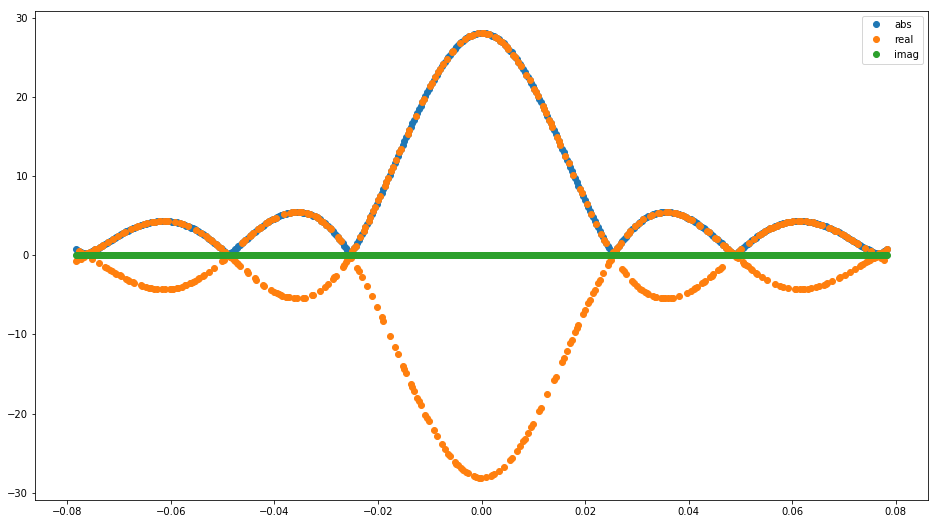

In [9]:
fig, ax = plt.subplots(figsize=(16,9))
for index, labelname in enumerate(['abs', 'real', 'imag']):
    ax.plot(phi_norm, values[index], label=labelname, linestyle='none', marker='o')
ax.legend()

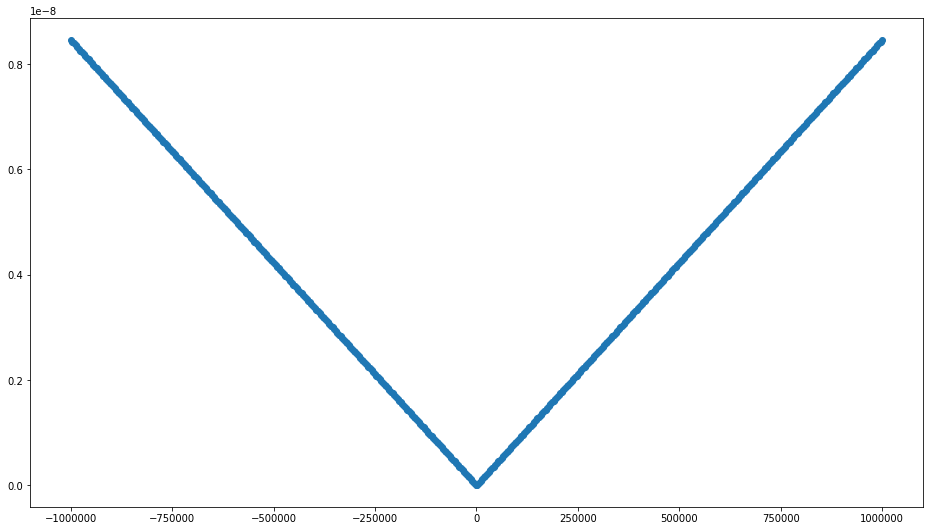

In [33]:
maxB = 9e-05
magnetic_field = np.linspace(-maxB, maxB, 500)
max_x = 
x = np.linspace(-max_x, max_x, 500)
fig, ax = plt.subplots(figsize=(16, 9))
density = transform_to_density(B=magnetic_field, Ic=(values[1], values[2]), x_values=x)
ax.plot(x, density, linestyle='none', marker='o')